# Assignment 2: Naive Bayes and Text Classification

Only use the already imported library `numpy`. Make sure that the `liar.txt` dataset is in the same directory as the notebook.

List your team members (name and immatriculation number) in the following cell:

- Group members:
  - Wang, Jiahui - B.Sc.Mathematik - 2992080 \\
  - Zhao, Jiaqi - M.Sc.Autonome System - 3470190 \\
  - Wang, Ziyin - M.Sc.Informatik - 3435397

In [1]:
# Load required packages and dataset. Do not modify.
import numpy as np


def load_liar_dataset():
    import string
    
    with open('liar.txt', mode='r', encoding='utf-8') as f:
        rows = [l.strip().split('\t')[:2] for l in f]
    
    y, X = zip(*rows)
    X =[x.translate(str.maketrans('', '', string.punctuation)).lower().split() for x in X]
    
    return X, y
    

X, y = load_liar_dataset()

print('Sample:')
print(f'{y[0]}: {X[0]}')
print(f'{y[2]}: {X[2]}')

Sample:
real: ['thanks', 'to', 'our', 'reforms', 'the', 'average', 'family', 'will', 'have', 'an', 'extra', '322', 'to', 'spend']
real: ['winning', 'enough', 'pledged', 'delegates', 'is', 'not', 'impossible']


## Task 2: Fake News Classification with Naive Bayes

Implement a Naive Bayes classifier with Laplace smoothing to detect whether a text message is fake or real (not fake).

A text message is represented by a list of string tokens as shown above.
The classification target is binary and the two possible labels are the strings `'fake'` and `'real'`.

Fill out the methods in `NaiveBayesFakeNewsClassifier` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed.

Hint: Try to map the text messages to word frequency vectors by counting how often each word occurs in a message.

In [2]:
# Implement your solution here.
class NaiveBayesFakeNewsClassifier(object):
    def __init__(self):
        self.tokens = {} # total different words, we use to calculate the prior probability
        self.tokens_real = {} # words with 'real'-label
        self.tokens_fake = {} # words with 'fake'-label
        
    
    def fit(self, X, y):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        y is a list of `n` labels either the string 'fake' or the string 'real'.
        """
        for i, snt in enumerate(X):
            word_arr, word_arr_cnt = np.unique(snt, return_counts=True)
            # total
            for j, (word, word_cnt) in enumerate(zip(word_arr, word_arr_cnt)):
                # tokens[word] = count [dictionary]
                if word not in self.tokens.keys():
                    # count the frequency(number) of each token(word)
                    self.tokens[word] = word_cnt
                    # inititalize real/fake token tables
                    self.tokens_real[word] = 0
                    self.tokens_fake[word] = 0
                else:
                    # if token exists, then just add current frequency(number) with previous frequency(number)
                    self.tokens[word] += word_cnt
                    
            # real
            if y[i] == 'real':
                word_arr_real, word_arr_real_cnt = np.unique(np.asarray(snt), return_counts=True)
                for (word_real, word_real_cnt) in zip(word_arr_real, word_arr_real_cnt):
                    if word_real not in self.tokens.keys():
                        self.tokens_real[word_real] = word_real_cnt
                    else:
                        self.tokens_real[word_real] += word_real_cnt

            # fake
            if y[i] == 'fake':
                word_arr_fake, word_arr_fake_cnt = np.unique(np.asarray(snt), return_counts=True)
                for (word_fake, word_fake_cnt) in zip(word_arr_fake, word_arr_fake_cnt):
                    if word_fake not in self.tokens.keys():
                        self.tokens_fake[word_fake] = word_fake_cnt
                    else:
                        self.tokens_fake[word_fake] += word_fake_cnt

    
    def predict(self, X):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        The method returns a list of `n` strings, i.e. classification labels ('fake' or 'real').
        """

        y_hat = [] 
        for i, sentence in enumerate(X):
            # 0. initialize the probability of each sentence: px_real, px_fake
            px_real, px_fake = 0, 0
            # 1. calculate the prior of 'real' and 'fake':
            # P(real) = cnt(real) / cnt(tokens), P(fake) = cnt(fake) / cnt(tokens)
            p_real = sum(self.tokens_real.values()) / sum(self.tokens.values())
            p_fake = sum(self.tokens_fake.values()) / sum(self.tokens.values())
            # use logrithm to calculate the probability of each sentence
            px_real += np.log(p_real)
            px_fake += np.log(p_fake)

            for word in sentence:
                # 2. calculate the word probability of 'real' and 'fake' of each sentence:
                # P(word | real) = (token_real[word] + 1) / (token_real.values().sum() + cnt(tokens_real.keys()))
                cnt_real_without_laplace = sum(self.tokens_real.values())
                cnt_real_laplace_smooth = cnt_real_without_laplace + len(self.tokens_real.keys())
                if word in self.tokens_real.keys():
                    cnt_real_word_laplace_smooth = self.tokens_real[word] + 1
                    p_word_real_xi = cnt_real_word_laplace_smooth / cnt_real_laplace_smooth
                    # p_real_word_arr[word] = p_word_xi
                    px_real += np.log(p_word_real_xi)

                # p_word_fake_xi = (tokens_fake[word] + 1) / (tokens_fake.values().sum() + len(tokens_fake.keys()))
                cnt_fake_without_laplace = sum(self.tokens_fake.values())
                cnt_fake_laplace_smooth = cnt_fake_without_laplace + len(self.tokens_fake.keys())
                if word in self.tokens_fake.keys():
                    cnt_fake_word_laplace_smooth = self.tokens_fake[word] + 1
                    p_word_fake_xi = cnt_fake_word_laplace_smooth / cnt_fake_laplace_smooth
                    # p_real_word_arr[word] = p_word_xi
                    px_fake += np.log(p_word_fake_xi)

            if px_fake > px_real:
                sentence_y = 'fake'
            else:
                sentence_y = 'real'

            y_hat.append(sentence_y)

        
        return y_hat


<ipython-input-3-ba0405e2fb0d>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'real', 'fake'])
<ipython-input-3-ba0405e2fb0d>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'real', 'fake'])


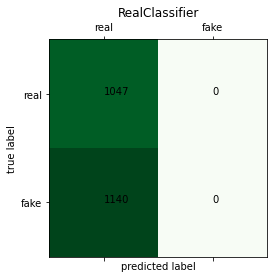

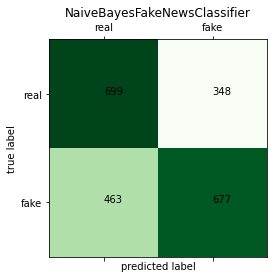

In [3]:
# The following code will evaluate your classifier.
class RealClassifier(object):
    """
    This classifier is a primitive baseline, which just predicts the most common class each time.
    Naive Bayes should definitely beat this.
    """
    def fit(self, X, y): pass
    def predict(self, X): return len(X)*['real']

    
def train_evaluate(classifier, X, y):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    
    # Apply train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    # Inititialize and train classifier.
    classifier.fit(X_train, y_train)
    # Evaluate classifier on test data.
    yhat_test = classifier.predict(X_test)
    # print(f'yhat_test: {yhat_test}')
    cmatrix = confusion_matrix(y_test, yhat_test, labels=['real', 'fake'])
    
    return cmatrix


def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in (0, 1):
        for y in (0, 1):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_xticklabels(['', 'real', 'fake'])
    ax.set_yticklabels(['', 'real', 'fake'])
    ax.set_title(classifier_name)


real_classifier = RealClassifier()
your_classifier = NaiveBayesFakeNewsClassifier()
real_cmatrix = train_evaluate(real_classifier, X, y)
your_cmatrix = train_evaluate(your_classifier, X, y)

plot_confusion_matrix(real_cmatrix, 'RealClassifier')
plot_confusion_matrix(your_cmatrix, 'NaiveBayesFakeNewsClassifier')